# GPU
## Unet for multi-class segmentation
Train and predict

## Chalange description

The data is 3D MRI images with 4 channels:
* Flair
* T1
* T1ce
* T2

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema 
* Label 4: enhancing tumor

In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:
> (155, 240, 240, 4)
> For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

In [1]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [2]:
DATA= 'dicom/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = 'dicom/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'/HGG/'
DATA_LGG = DATA +'/LGG/'

NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Training/numpy_images/'
VALIDATION_NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Validation/numpy_images/'
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [3]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [4]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [5]:
import pandas
import numpy

In [6]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random
from random import randrange
from keras.utils import np_utils

Using TensorFlow backend.


## Visualization utilities

In [7]:
from importlib import reload  # Python 3.4+ only.
import visualization_utils  as vu
from visualization_utils import show_lable_on_image4
reload(vu)

<module 'visualization_utils' from '/home/lab11/naomi/visualization_utils.py'>

In [8]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.] #[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [9]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);
    

In [10]:
def show_lable(lbl):
    
    
    vu.show_n_images([lbl[:,:,k] for k in range(4)]+[lbl_from_cat(lbl)],
                 titles = label_type_shrt + ['Label']) 

In [11]:
def show_pred_im_lable(im, lb, pred):
    lb[0,0]=1
    lb[0,1]=2
    lb[0,2]=3
    pred[0,0]=1
    pred[0,1]=2
    pred[0,2]=3
    vu.show_n_images([pred[:,:], lb[:,:], 
                   show_lable_on_image4(im[:,:,1], lb[:,:]),
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Prediction', 'Label', 'Label on T1', 'Prediction on Flair'])

In [12]:
def show_pred_im(im, pred):
    pred[0,0]=1
    pred[0,1]=2
    pred[0,2]=3    
    vu.show_n_images([im[:,:,1], 
                   im[:,:,0],pred,
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair','T1', 'Pred',  'Prediction on Flair'])

In [13]:
def print_info(imgs):
    for img in imgs:
        print('shape {} min {:.5} max {:3.5} mean: {:.5} std: {:.5}'.format(img.shape, float(img.min()), float(img.max()),float(img.mean()), img.std()))        

## Read image description files
In the preprocessing notebook, all files where saved as numpy.

Some statistics on the labels were collected, to assist the training phase.

In [14]:
df_train= pd.read_csv('df_train.csv')
df_test= pd.read_csv('df_test.csv')
df_val= pd.read_csv('df_val.csv')

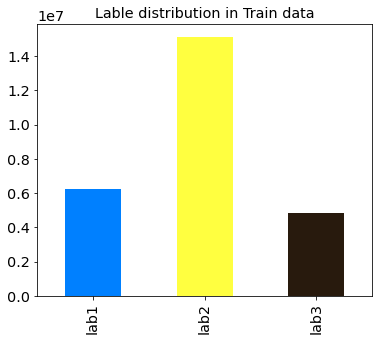

In [15]:
df_train[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Train data')

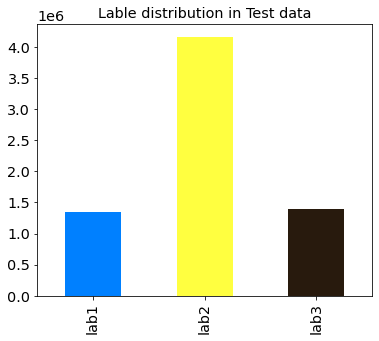

In [16]:
df_test[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Test data')

## Build Train generator

In [17]:
# Read numpy image file and label file
def get_numpy_img_lbl(img_id = 'BraTS19_TCIA10_449_1', np_dir=NUMPY_DIR):
    img=np.load(os.path.join(np_dir, img_id+'.npy'))
    lbl=np.load(os.path.join(np_dir, img_id+'_lbl.npy'))
    return img,lbl

In [18]:
# return random plane with non-zero label
def get_random_img(axis=0, df=df_train, np_dir=NUMPY_DIR):
    
    ind = randrange(len(df))
    img_id= df.iloc[ind].id
    img,lbl = get_numpy_img_lbl(img_id, np_dir=NUMPY_DIR)
        
    if (axis==0):
        x = randrange(df.iloc[ind].rmin, df.iloc[ind].rmax+1)
        return img[ x,:,:, :], lbl[x,:,:]

    im = np.zeros((240,240,4),dtype=np.float32)    
    lb = np.zeros((240,240),dtype=np.int)
        
    if (axis==1):
        y = randrange(df.iloc[ind].cmin, df.iloc[ind].cmax+1)
        im[40:40+155,:,:]=img[:, y,:, :]
        lb[40:40+155,:]=lbl[:, y,:]
        return im,lb
    
    if (axis == 2):
        z = randrange(df.iloc[ind].zmin, df.iloc[ind].zmax+1)
        im[40:40+155,:,:]=img[:,:, z, :]
        lb[40:40+155,:]=lbl[:,:,z]
        return im,lb
    return None    

<Figure size 432x360 with 0 Axes>

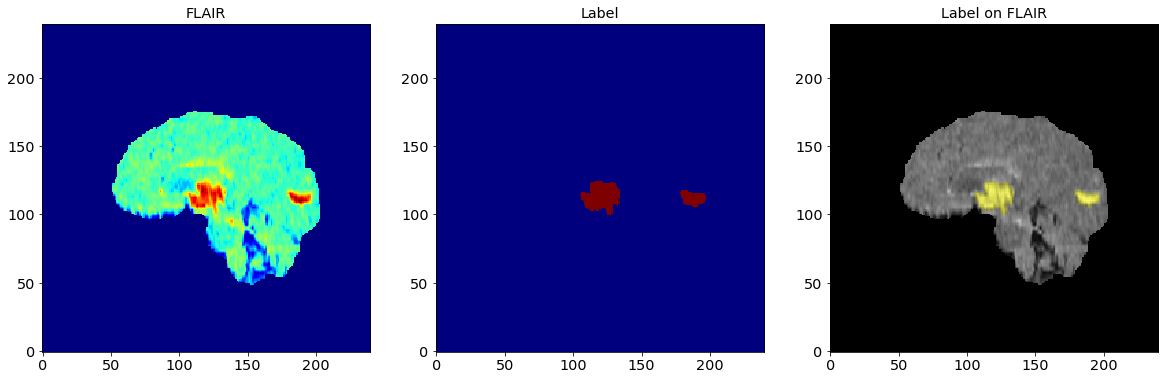

In [19]:
img,lbl = get_random_img(2)
show_img_lable(img, lbl)

Function randomly selects a 2D image that includes the given label

In [20]:
def get_img_for_label(lab=2, axis=0, df=df_train,np_dir = NUMPY_DIR):
    
    img_id= random.choice(df[df['lab'+str(lab)] > 0].id.values)
    
    img,lbl = get_numpy_img_lbl(img_id, np_dir)
    ind = np.where(lbl==lab)
    k = random.randrange(len(ind[0]))
    
    if (axis==0):        
        return img[ind[0][k],:,:] , lbl[ind[0][k],:,:]
        
    lb = np.zeros((240,240),dtype=np.int)
    im = np.zeros((240,240,4),dtype=np.float32)
    
    if (axis==1):
        im[40:40+155,:,:]=img[:, ind[1][k],:,:]
        lb[40:40+155,:]=lbl[:, ind[1][k],:]
        return im,lb
    
    if (axis == 2):
        im[40:40+155,:,:]=img[:, :, ind[2][k],:]
        lb[40:40+155,:]=lbl[:,:,ind[2][k]]
        return im,lb
    return None

<Figure size 432x360 with 0 Axes>

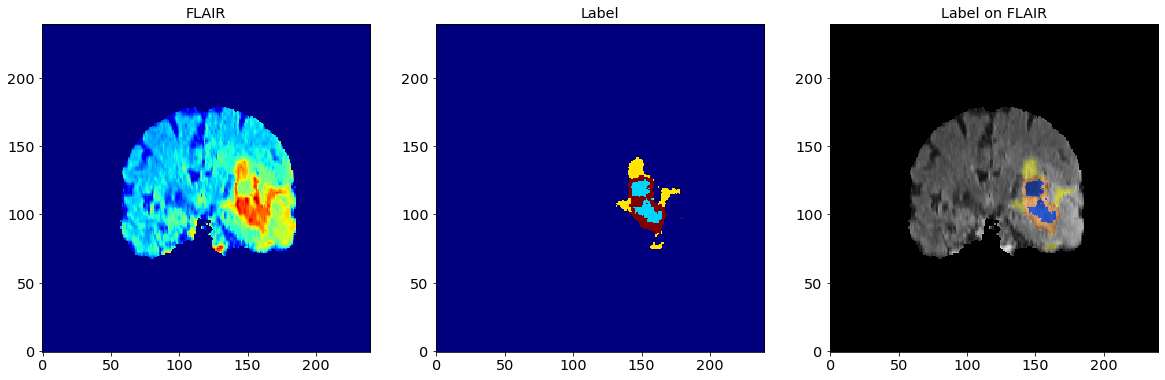

In [21]:
img,lbl = get_img_for_label(1,1)
show_img_lable(img, lbl)

In [22]:
np.unique(lbl)

array([0, 1, 2, 3])

<Figure size 432x360 with 0 Axes>

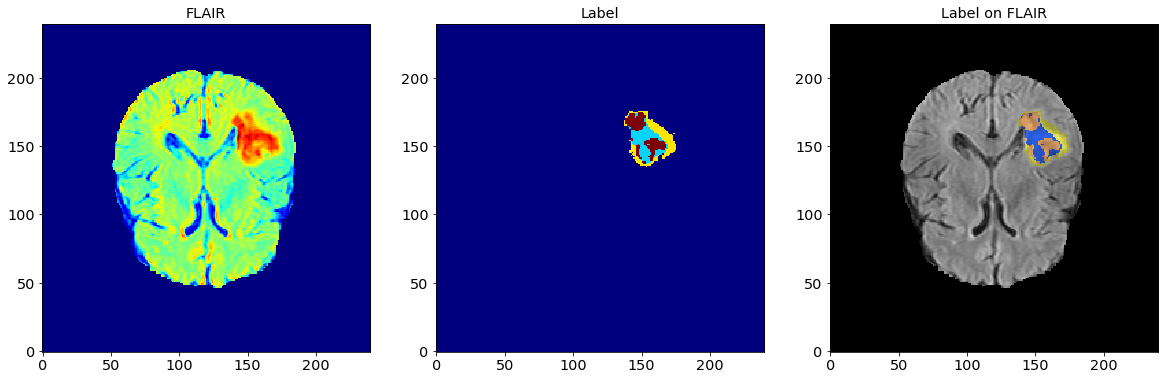

In [23]:
img,lbl = get_img_for_label(3,0)
show_img_lable(img, lbl)

In [24]:
lbl.shape

(240, 240)

<Figure size 432x360 with 0 Axes>

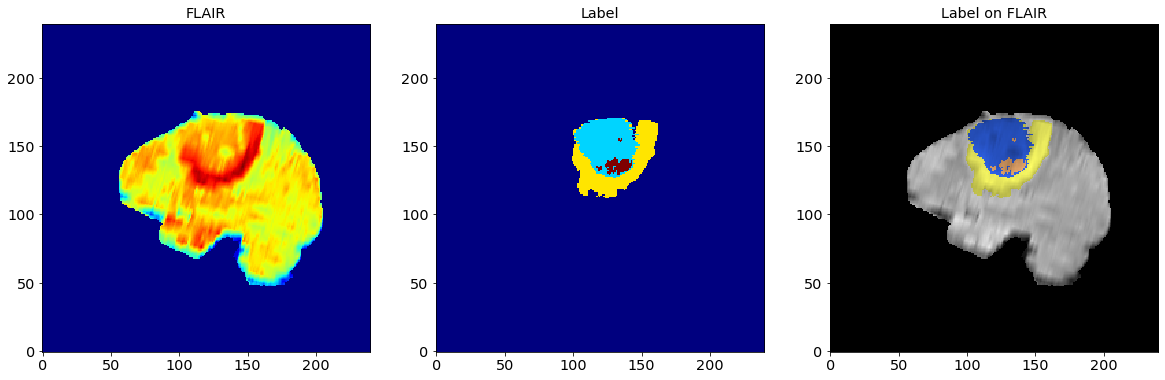

In [25]:
img,lbl = get_img_for_label(2,2)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

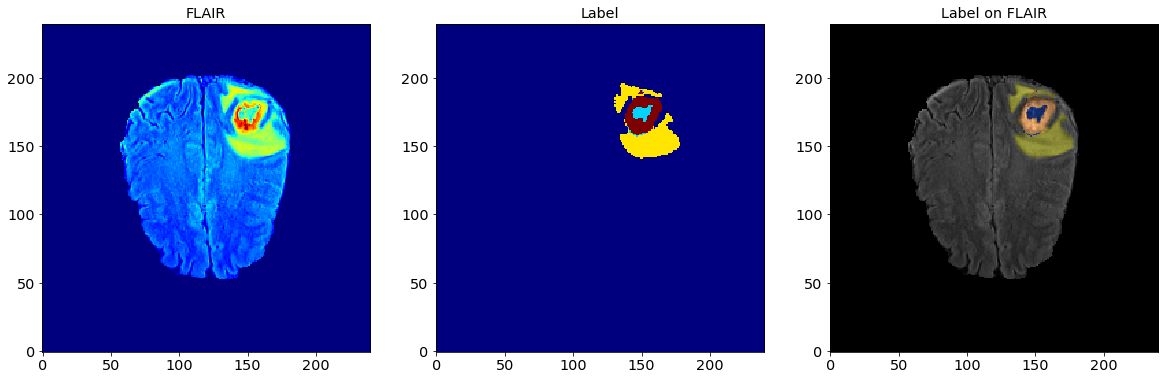

In [26]:
img,lbl = get_img_for_label(1,0)
show_img_lable(img, lbl)

In [27]:
# Return label from categorical
def lbl_from_cat(cat_lbl):
    
    lbl=0
    if (len(cat_lbl.shape)==3):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,i]*i
    elif (len(cat_lbl.shape)==4):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,:,i]*i
    else:
        print('Error in lbl_from_cat', cat_lbl.shape)
        return None
    return lbl

For test we will create batch from few test images. only planes with lables >0 will be included.

In [28]:
def normalize_2D_image(img):
    v_max = img.max(axis=(0, 1), keepdims=True)
    v_max = np.where(np.abs(v_max) <= 0.000001, 1., v_max)
 
    return (img)/(v_max)

In [29]:
def normalize_3D_image(img):
    for z in range(img.shape[0]):
        img[z] = normalize_2D_image(img[z])
    return img

Function returns all z-planes of the image that have non-zerolable

In [30]:
def get_img_batch(row, np_dir=NUMPY_DIR):
    
    im,lb = get_numpy_img_lbl(row['id'], np_dir)
    
    n_im = row['rmax']-row['rmin']
    rmin=row['rmin']
    rmax=row['rmax']
    
    return normalize_3D_image(im[rmin:rmax]), np_utils.to_categorical(lb[rmin:rmax],4)

<Figure size 432x360 with 0 Axes>

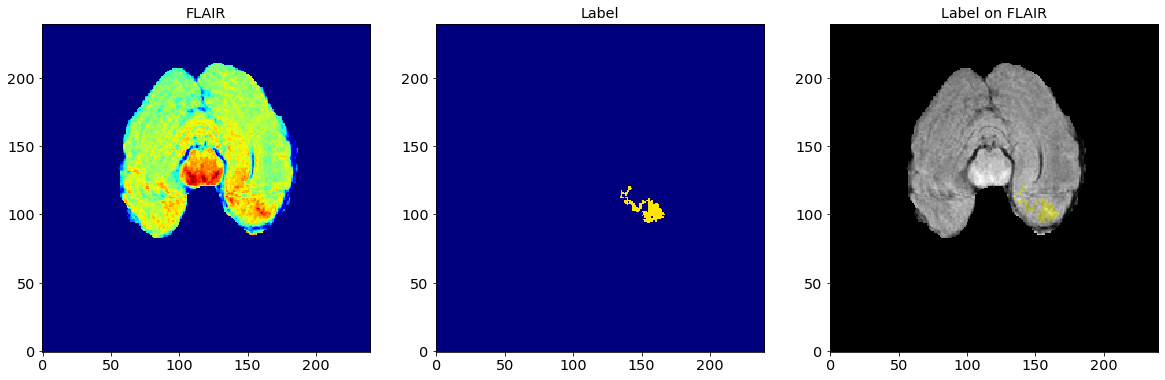

In [31]:
im, lb = get_img_batch(df_test.iloc[0])
im.shape, lb.shape
show_img_lable(im[6], lb[6])

<Figure size 432x360 with 0 Axes>

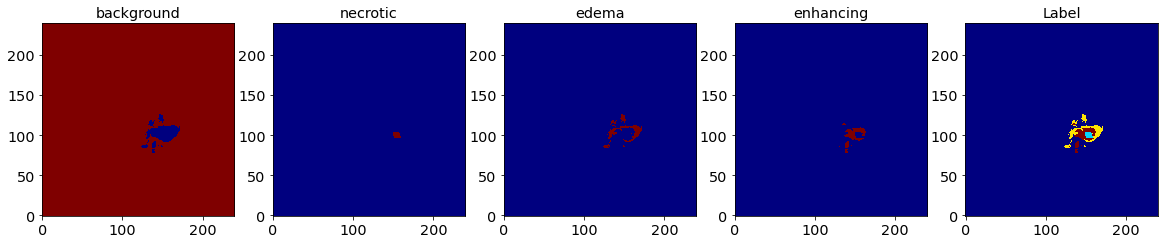

In [32]:
i=15
show_lable(lb[i])

<Figure size 432x360 with 0 Axes>

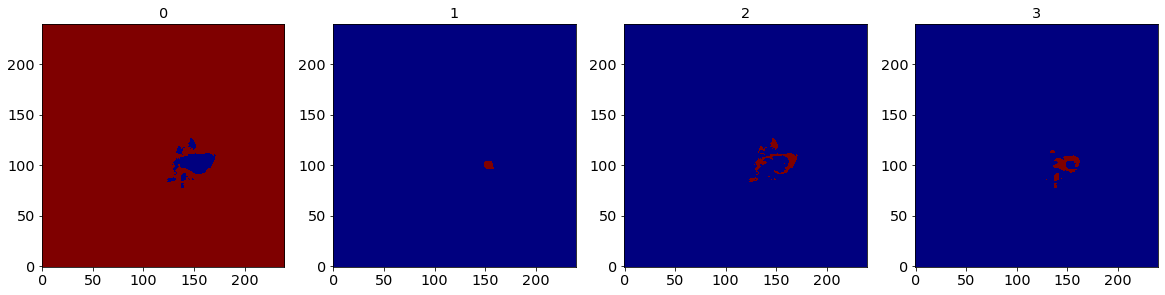

In [33]:
vu.show_n_images([lb[i, :,:,k] for k in range(4)], titles=[0,1,2,3])

Get images with non-zero labels from all raws of given data frame

In [34]:
def get_df_img_batch(df_batch, np_dir=NUMPY_DIR):
    
        n_images = (df_batch.rmax - df_batch.rmin).sum()
        b_images = np.zeros((n_images, 240, 240, 4), np.float32)
        b_label = np.zeros((n_images, 240, 240, 4), np.int8)    
        ind=0
        for index, row in df_batch.iterrows():
 
            b_im, b_lb = get_img_batch(row, np_dir)
            n_im = b_im.shape[0]
            b_images[ind:ind+n_im] = b_im
            b_label[ind:ind+n_im] = b_lb
            ind+=n_im
               
        return b_images, b_label

<Figure size 432x360 with 0 Axes>

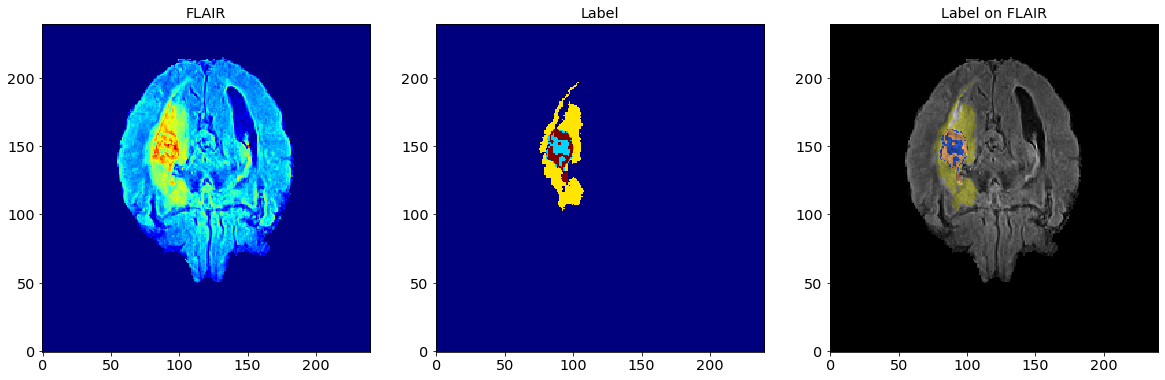

In [35]:
im, lb = get_df_img_batch(df_test.iloc[0:3])
show_img_lable(im[100],lb[100])

In [36]:
from keras.utils import np_utils
def generate_im_test_batch(n_images = 3, batch_size=30, df = df_test, np_dir=NUMPY_DIR):

    while 1:
         
        df_batch = df.sample(n_images)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        if (batch_size > 0):
            b_images = b_images[0:batch_size]
            b_label = b_label[0:batch_size]
            
        yield b_images, b_label

In [37]:
%%time
gen_test_im = generate_im_test_batch(5) #600
imtest,lbtest = next(gen_test_im)
imtest.shape, lbtest.shape

CPU times: user 996 ms, sys: 1.18 s, total: 2.18 s
Wall time: 6.17 s


((30, 240, 240, 4), (30, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

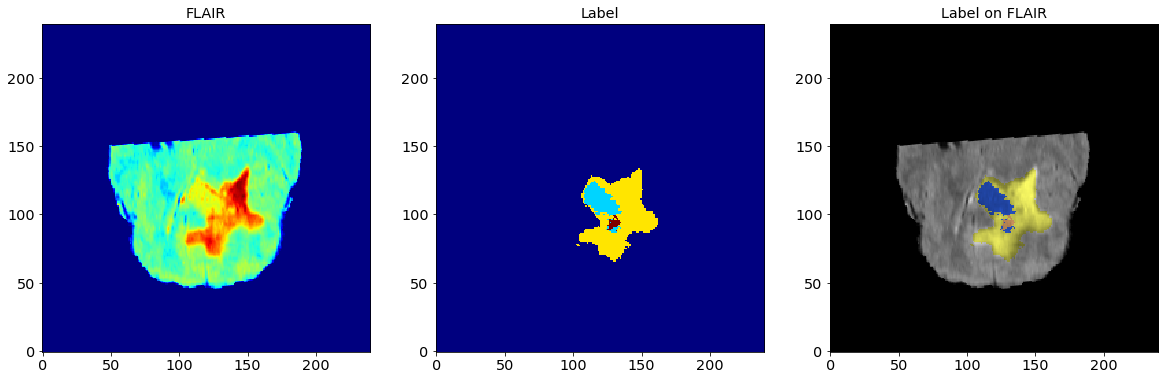

In [38]:
show_img_lable(imtest[10], lbtest[10])

<Figure size 432x360 with 0 Axes>

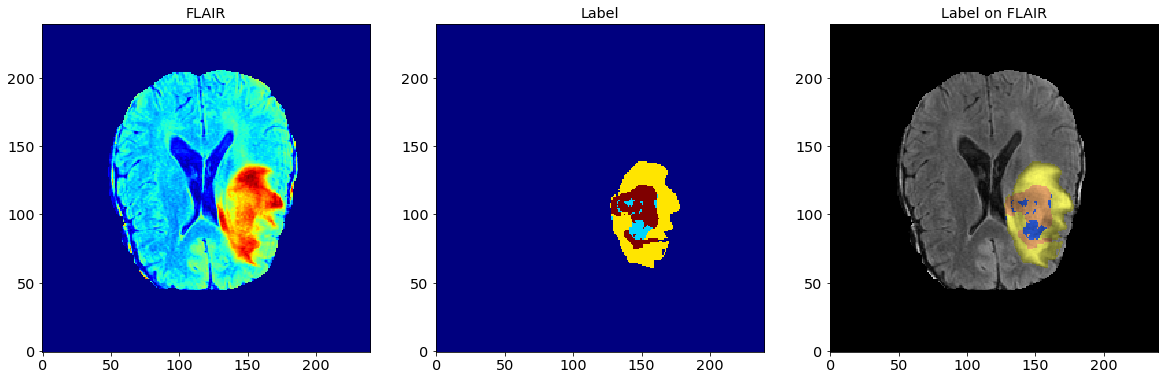

<Figure size 432x360 with 0 Axes>

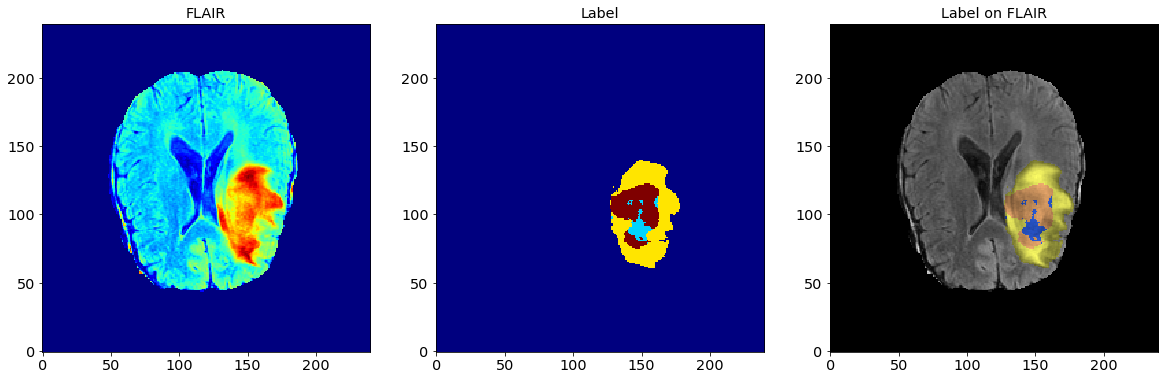

In [39]:
ind=[6,8]
for i in ind:show_img_lable(imtest[i], lbtest[i])

## Augmentation

In [40]:
! pip install imgaug

Defaulting to user installation because normal site-packages is not writeable


In [41]:
import imageio
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

### Rotate

In [42]:
def rot_2D_random(img, lbl):
    
    segmap = SegmentationMapsOnImage(lbl.astype(np.int8, copy=False), shape=lbl.shape)
    
    aug = iaa.Affine(rotate=(-90, 90))
    
    img,lbl_aug = aug(image=img, segmentation_maps=segmap)
   
    lbl = lbl_aug.get_arr()

    return img, lbl

In [43]:
def rot_2D_batch_random(imgages, lbl, rotate=(-45, 45)):
    
    for i in range(len(imgages)):
        imgages[i], lbl[i] = rot_2D_random(imgages[i], lbl[i])

    return imgages, lbl

In [44]:
i=8
rot_im, rot_la = rot_2D_random(imtest[i], lbtest[i])
rot_im.shape, rot_la.shape, imtest.shape, lbl_from_cat(lbtest).shape

((240, 240, 4), (240, 240, 4), (30, 240, 240, 4), (30, 240, 240))

<Figure size 432x360 with 0 Axes>

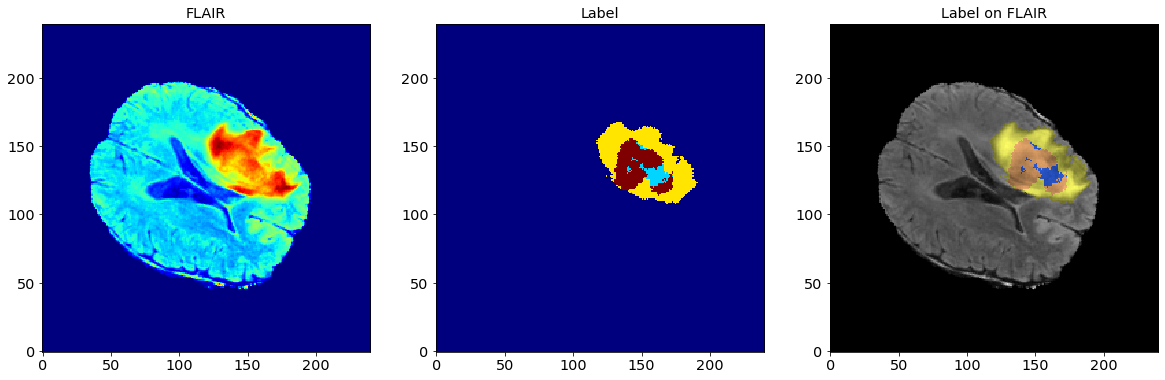

In [45]:
show_img_lable(rot_im, rot_la)

<Figure size 432x360 with 0 Axes>

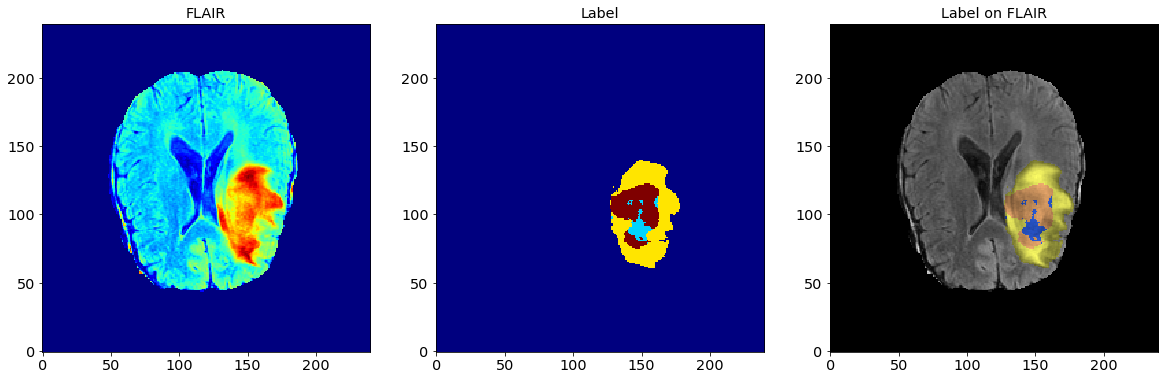

In [46]:
show_img_lable(imtest[i], lbtest[i])

<Figure size 432x360 with 0 Axes>

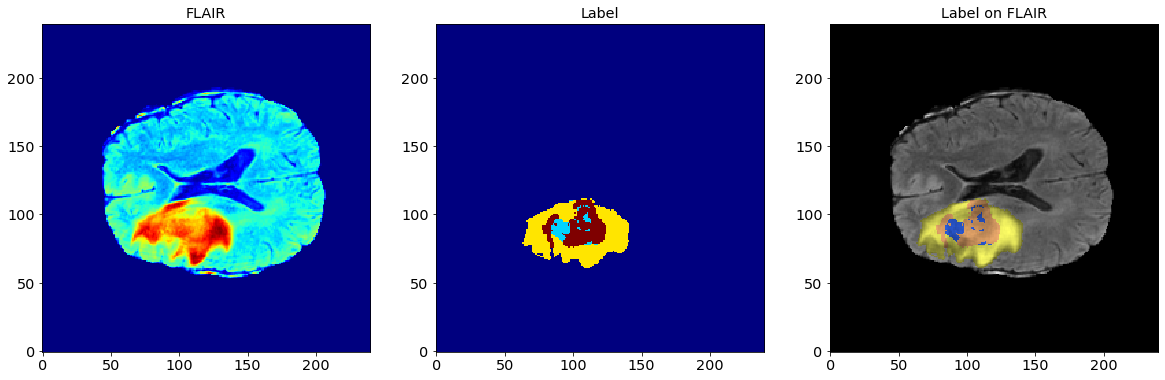

In [47]:
i=6
rot_im, rot_la = rot_2D_random(imtest[i], lbtest[i])
show_img_lable(rot_im, rot_la)

### Flip

In [49]:
def random_flip_2D(bimg, blbl):
        
        aug = np.random.randint(1,5)
        
        if (aug==1):
            for j in range(4):
                bimg[:,:,j] = np.flipud(bimg[:,:,j])
            if (len(blbl.shape) == 2):
                blbl = np.flipud(blbl)
            else:
                for j in range(blbl.shape[2]):
                    blbl[:,:,j] = np.flipud(blbl[:,:,j])
            
        elif (aug==2):
            for j in range(4):
                bimg[:,:,j] = np.fliplr(bimg[:,:,j])
            if (len(blbl.shape) == 2):
                blbl = np.fliplr(blbl)
            else:
                for j in range(blbl.shape[2]):
                    blbl[:,:,j] = np.fliplr(blbl[:,:,j])

        elif (aug==3):
            for j in range(4):
                bimg[:,:,j] = np.rot90(bimg[:,:,j])
            if (len(blbl.shape) == 2):
                blbl = np.rot90(blbl)
            else:
                for j in range(blbl.shape[2]):
                    blbl[:,:,j] = np.rot90(blbl[:,:,j])

        return bimg, blbl    

<Figure size 432x360 with 0 Axes>

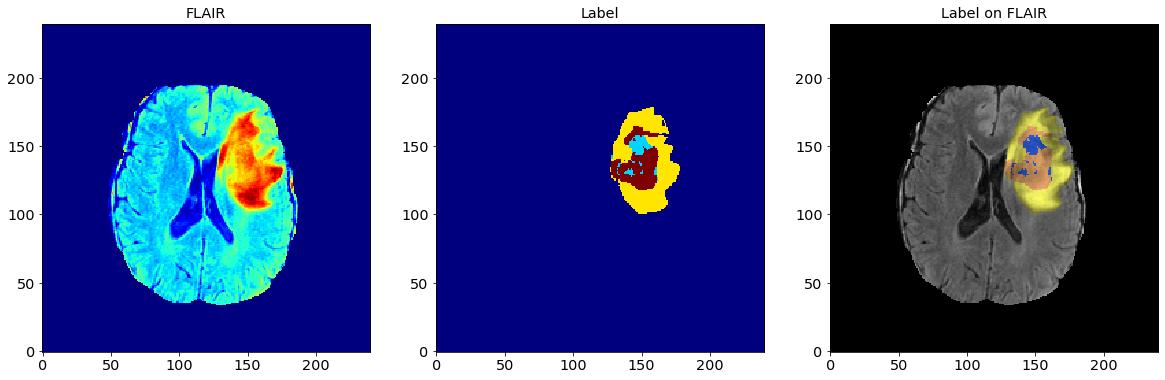

In [50]:
i=6
aug_im, aug_la = random_flip_2D(imtest[i], lbtest[i])
show_img_lable(aug_im, aug_la)

In [51]:
def aug_batch(imgages,lbl, n_aug):
    

    ind = np.random.choice(len(imgages), n_aug)
    for i in ind:
        imgages[i], lbl[i] = rot_2D_random(imgages[i], lbl[i])
        
    ind = np.random.choice(len(imgages), min(6*n_aug, len(imgages)-1))
    
    for i in ind:
        imgages[i], lbl[i] = random_flip_2D(imgages[i], lbl[i])
        imgages[i], lbl[i] = random_flip_2D(imgages[i], lbl[i])
    return imgages,lbl
    

## Train Batch Generator

In [52]:
def generate_train_batch(batch_size = 12, df = df_train, n_aug=2):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 1), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while 1:
         
        i = 0
        
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1
            
        
        # lab 2
        nim = batch_size//2
        for j in range(nim):
            im,lbl = get_img_for_label(lab=2, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1
            
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1

        # The rest
        nim = batch_size - i
        for j in range(nim):
            im,lbl = get_random_img(axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1
                    
        batch_images, batch_label = shuffle(batch_images, batch_label)
        batch_images, batch_label = aug_batch(batch_images, batch_label, n_aug)    
        yield batch_images, np_utils.to_categorical(batch_label, 4)

In [53]:
%%time
gen_train = generate_train_batch(batch_size=8)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

CPU times: user 320 ms, sys: 1.58 s, total: 1.9 s
Wall time: 8.94 s


((8, 240, 240, 4), (8, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

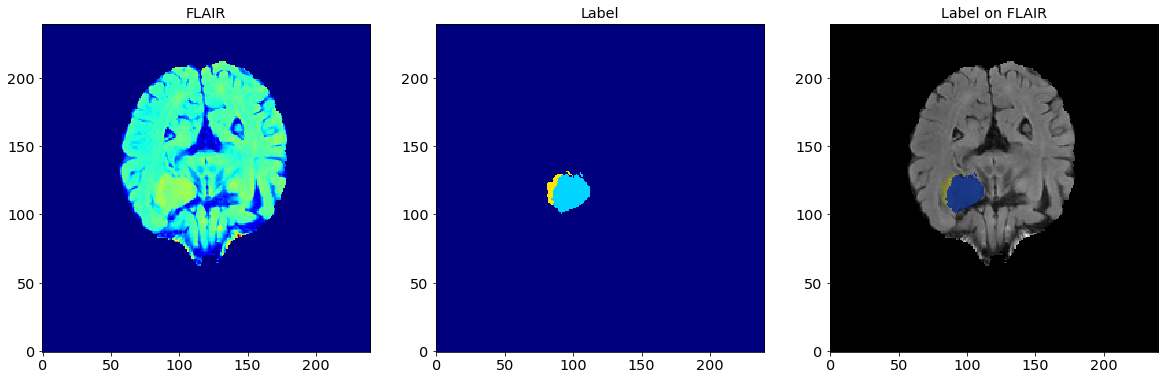

In [54]:
i=0
show_img_lable(bimg[i], blbl[i])

In [55]:
%%time
gen_test = generate_train_batch(36,df_test)
bimg,blbl = next(gen_test)
bimg.shape, blbl.shape

CPU times: user 1.22 s, sys: 6.2 s, total: 7.42 s
Wall time: 39 s


((36, 240, 240, 4), (36, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

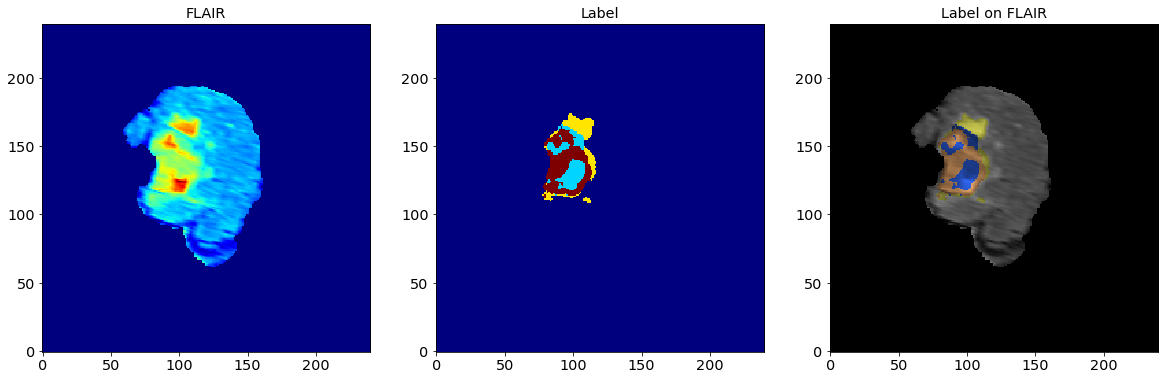

In [56]:
i=6
show_img_lable(bimg[i], blbl[i])

## define Base Unet Model

In [57]:
import tensorflow as tf
from keras import backend as K

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Input, UpSampling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [58]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_CHANNELS = 4

In [59]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [60]:
import model_unet
reload(model_unet)

<module 'model_unet' from '/home/lab11/naomi/model_unet.py'>

In [61]:
import tensorflow as tf
print(tf.__version__)
#print(tf.config.list_physical_devices())

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2.2.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9254997620622499026,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11986934894945378375
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13993643153995557578
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14784367168
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9084689083833365078
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"]

### One GPU version

In [63]:
import model_unet

model = model_unet.unet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [65]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_2.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

log_dir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [68]:
%%time
history = model.fit_generator(gen_train,steps_per_epoch=20,
                                        validation_data =( bimg,blbl), 
                              #validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=10,
                    callbacks=[earlystopper, checkpointer])

Epoch 1/10
20/20 [==============================] - 202s 10s/step - loss: 0.4411 - accuracy: 0.9209 - val_loss: 0.1408 - val_accuracy: 0.9640

Epoch 00001: val_loss improved from inf to 0.14084, saving model to model_unet_4ch_2.hdf5
Epoch 2/10
20/20 [==============================] - 194s 10s/step - loss: 0.1213 - accuracy: 0.9653 - val_loss: 0.1063 - val_accuracy: 0.9641

Epoch 00002: val_loss improved from 0.14084 to 0.10631, saving model to model_unet_4ch_2.hdf5
Epoch 3/10
20/20 [==============================] - 195s 10s/step - loss: 0.1066 - accuracy: 0.9681 - val_loss: 0.1063 - val_accuracy: 0.9656

Epoch 00003: val_loss improved from 0.10631 to 0.10626, saving model to model_unet_4ch_2.hdf5
Epoch 4/10
20/20 [==============================] - 201s 10s/step - loss: 0.0969 - accuracy: 0.9714 - val_loss: 0.0926 - val_accuracy: 0.9708

Epoch 00004: val_loss improved from 0.10626 to 0.09261, saving model to model_unet_4ch_2.hdf5
Epoch 5/10
20/20 [==============================] - 204s

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


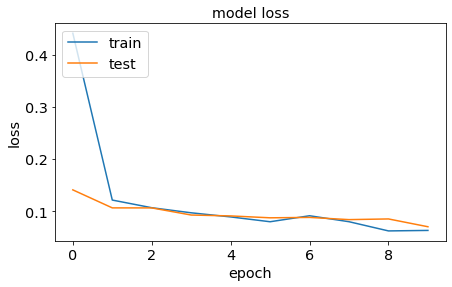

In [69]:
vu.drow_history(history)

In [70]:
model.save_weights('model_unet_4ch_2.hdf5')

In [77]:
model.load_weights('model_unet_4ch.hdf5')

In [74]:
%%time
history2 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        validation_data =( imtest,lbtest), 
                              #validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer])

Epoch 1/100
20/20 [==============================] - 201s 10s/step - loss: 0.0719 - accuracy: 0.9763 - val_loss: 0.0973 - val_accuracy: 0.9664

Epoch 00001: val_loss did not improve from 0.07015
Epoch 2/100
20/20 [==============================] - 200s 10s/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 0.0674 - val_accuracy: 0.9769

Epoch 00002: val_loss improved from 0.07015 to 0.06742, saving model to model_unet_4ch_2.hdf5
Epoch 3/100
20/20 [==============================] - 193s 10s/step - loss: 0.0582 - accuracy: 0.9792 - val_loss: 0.0541 - val_accuracy: 0.9820

Epoch 00003: val_loss improved from 0.06742 to 0.05407, saving model to model_unet_4ch_2.hdf5
Epoch 4/100
20/20 [==============================] - 196s 10s/step - loss: 0.0543 - accuracy: 0.9813 - val_loss: 0.0483 - val_accuracy: 0.9853

Epoch 00004: val_loss improved from 0.05407 to 0.04828, saving model to model_unet_4ch_2.hdf5
Epoch 5/100
20/20 [==============================] - 197s 10s/step - loss: 0.0509 - accurac

In [78]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_3.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_3.hdf5',
                               verbose=1, monitor='val_accuracy',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [79]:
model.compile(loss='categorical_crossentropy',
                       optimizer = Adam(lr = 0.00001),
                      metrics=['accuracy'])

In [80]:
model.load_weights('model_unet_4ch_2.hdf5')

In [67]:
%%time
history3 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 282s 14s/step - loss: 0.0464 - accuracy: 0.9827 - val_loss: 0.0429 - val_accuracy: 0.9870

Epoch 00001: val_loss improved from inf to 0.04289, saving model to model_unet_4ch_3.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.98700, saving model to model_unet_best_acc_4ch_3.hdf5
Epoch 2/100
20/20 [==============================] - 216s 11s/step - loss: 0.0450 - accuracy: 0.9840 - val_loss: 0.0499 - val_accuracy: 0.9790

Epoch 00002: val_loss did not improve from 0.04289

Epoch 00002: val_accuracy did not improve from 0.98700
Epoch 3/100
20/20 [==============================] - 310s 15s/step - loss: 0.0455 - accuracy: 0.9834 - val_loss: 0.0271 - val_accuracy: 0.9893

Epoch 00003: val_loss improved from 0.04289 to 0.02707, saving model to model_unet_4ch_3.hdf5

Epoch 00003: val_accuracy improved from 0.98700 to 0.98934, saving model to model_unet_best_acc_4ch_3.hdf5
Epoch 4/100


/home/lab11/.local/lib/python3.7/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


20/20 [==============================] - 558s 28s/step - loss: 0.0468 - accuracy: 0.9830 - val_loss: 0.0343 - val_accuracy: 0.9858

Epoch 00004: val_loss did not improve from 0.02707

Epoch 00004: val_accuracy did not improve from 0.98934
Epoch 5/100
20/20 [==============================] - 554s 28s/step - loss: 0.0448 - accuracy: 0.9839 - val_loss: 0.0446 - val_accuracy: 0.9865

Epoch 00005: val_loss did not improve from 0.02707

Epoch 00005: val_accuracy did not improve from 0.98934
Epoch 6/100
20/20 [==============================] - 542s 27s/step - loss: 0.0456 - accuracy: 0.9832 - val_loss: 0.0257 - val_accuracy: 0.9875

Epoch 00006: val_loss improved from 0.02707 to 0.02569, saving model to model_unet_4ch_3.hdf5

Epoch 00006: val_accuracy did not improve from 0.98934
Epoch 7/100
20/20 [==============================] - 546s 27s/step - loss: 0.0508 - accuracy: 0.9814 - val_loss: 0.0484 - val_accuracy: 0.9801

Epoch 00007: val_loss did not improve from 0.02569

Epoch 00007: val_acc

## Loss functions

In [81]:
from keras import backend as K
from keras.layers import Input, MaxPooling2D, UpSampling2D, Conv2D
from keras.layers import concatenate
from keras.models import Model
from keras.optimizers import Adam

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [82]:
def dice_coef4(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,1:4])
    y_pred_f = K.flatten(y_pred[:,:,:,1:4])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss4(y_true, y_pred):
    return -dice_coef4(y_true, y_pred)

In [83]:
def logit_categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

In [84]:
def logit_categorical_crossentropy4(y_true, y_pred):
    return K.categorical_crossentropy(y_true[:,:,:,1:4], y_pred[:,:,:,1:4], from_logits=True)

In [85]:
def categorical_crossentropy4(y_true, y_pred):
    return K.categorical_crossentropy(y_true[:,:,:,1:4], y_pred[:,:,:,1:4])

In [86]:
import keras
def accuracy4(y_true, y_pred):
    return keras.metrics.accuracy(y_true[:,:,:,1:4], y_pred[:,:,:,1:4])

In [87]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [88]:
def jaccard_distance_loss4(y_true, y_pred, smooth=100):

    intersection = K.sum(K.abs(y_true[:,:,:,1:4] * y_pred[:,:,:,1:4]), axis=-1)
    sum_ = K.sum(K.abs(y_true[:,:,:,1:4]) + K.abs(y_pred[:,:,:,1:4]), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [89]:
def jac_dice4(y_true, y_pred):
    
    return jaccard_distance_loss4(y_true, y_pred) - 1. -dice_coef4(y_true, y_pred)-dice_coef(y_true, y_pred)*0.5

In [90]:
def jac_dice_cross4(y_true, y_pred):
    
    return jac_dice4(y_true, y_pred)-(1.-logit_categorical_crossentropy4(y_true, y_pred))-dice_coef(y_true, y_pred)*0.5

In [91]:
model.load_weights('model_unet_4ch_3.hdf5')

In [92]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_dice.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_dice.hdf5',
                               verbose=1, monitor='val_accuracy',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [93]:
model.compile(loss=dice_coef_loss,
                       optimizer = Adam(lr = 0.0001),
                      metrics=['accuracy', 'categorical_crossentropy'])

In [77]:
%%time
history4 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 289s 14s/step - loss: -0.9761 - accuracy: 0.9775 - categorical_crossentropy: 0.1010 - val_loss: -0.9809 - val_accuracy: 0.9840 - val_categorical_crossentropy: 0.1227

Epoch 00001: val_loss improved from inf to -0.98089, saving model to model_unet_4ch_dice.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.98396, saving model to model_unet_best_acc_4ch_dice.hdf5
Epoch 2/100
20/20 [==============================] - 210s 10s/step - loss: -0.9787 - accuracy: 0.9796 - categorical_crossentropy: 0.1249 - val_loss: -0.9840 - val_accuracy: 0.9824 - val_categorical_crossentropy: 0.0669

Epoch 00002: val_loss improved from -0.98089 to -0.98401, saving model to model_unet_4ch_dice.hdf5

Epoch 00002: val_accuracy did not improve from 0.98396
Epoch 3/100
20/20 [==============================] - 219s 11s/step - loss: -0.9798 - accuracy: 0.9803 - categorical_crossentropy: 0.1154 - val_loss: -0.9708 - val_accuracy: 0.9769 - val_categorical_cross

### Enlarge Train group

In [94]:
df_test.shape, df_train.shape

((67, 12), (268, 12))

In [95]:
df_test.head()

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,HGG,BraTS19_TCIA01_203_1,8741311,16013,91667,79009,39,114,57,152,77,173
1,HGG,BraTS19_CBICA_AYA_1,8888589,2853,32237,4321,31,84,99,200,73,119
2,HGG,BraTS19_CBICA_BAP_1,8893689,595,24175,9541,51,113,97,177,113,168
3,HGG,BraTS19_TCIA02_331_1,8861184,736,48139,17941,38,122,137,208,119,168
4,HGG,BraTS19_TCIA01_231_1,8832609,3277,66878,25236,61,128,71,149,122,173


In [96]:
df_test=df_test.sort_values(['lab1','lab3']).reset_index()
df_test.tail()

,index,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
62,34,HGG,BraTS19_2013_20_1,8710620,64066,109935,43379,59,142,48,153,98,176
63,26,LGG,BraTS19_TCIA09_141_1,8737749,93298,7407,89546,57,137,54,138,60,150
64,33,LGG,BraTS19_TCIA10_351_1,8747276,97103,83621,0,55,136,49,175,97,176
65,25,LGG,BraTS19_TCIA10_393_1,8731819,138162,54457,3562,55,133,42,148,70,152
66,32,LGG,BraTS19_TCIA10_261_1,8725573,146041,49316,7070,58,133,50,148,54,145


In [97]:
df_test2 = df_test.iloc[44:].copy()
df_test2['Grade'].value_counts()

HGG    13
LGG    10
Name: Grade, dtype: int64

In [98]:
df_train['Grade'].value_counts()

HGG    206
LGG     62
Name: Grade, dtype: int64

In [99]:
df_train2 = pd.concat([df_train, df_test.iloc[0:44].copy()], axis=1)
df_train2.head()

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,...,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,HGG,BraTS19_CBICA_ABE_1,8788770,19827,94456,24947,59,134,53,152,...,8912238.0,86.0,12890.0,2786.0,46.0,136.0,105.0,167.0,119.0,161.0
1,HGG,BraTS19_CBICA_BHB_1,8907248,455,20191,106,24,70,88,158,...,8908850.0,402.0,17336.0,1412.0,70.0,134.0,82.0,142.0,83.0,137.0
2,HGG,BraTS19_CBICA_AOH_1,8891142,2666,31189,3003,81,131,67,151,...,8893689.0,595.0,24175.0,9541.0,51.0,113.0,97.0,177.0,113.0,168.0
3,HGG,BraTS19_CBICA_AME_1,8847604,9313,52828,18255,26,89,93,186,...,8861184.0,736.0,48139.0,17941.0,38.0,122.0,137.0,208.0,119.0,168.0
4,HGG,BraTS19_TCIA01_390_1,8793729,25826,94553,13892,60,134,96,189,...,8902082.0,901.0,23845.0,1172.0,33.0,86.0,84.0,147.0,120.0,172.0


In [100]:
df_test=df_test2
df_train=df_train2

In [101]:
model.compile(loss=dice_coef_loss4,
                       optimizer = Adam(lr = 0.00001),
                      metrics=[accuracy4, categorical_crossentropy4])

In [102]:
model.load_weights('model_unet_4ch_dice.hdf5')

In [103]:
%%time
gen_train = generate_train_batch(batch_size=8, n_aug=4)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

CPU times: user 376 ms, sys: 2.63 s, total: 3 s
Wall time: 11.2 s


((8, 240, 240, 4), (8, 240, 240, 4))

In [104]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_dice4.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_dice4.hdf5',
                               verbose=1, monitor='val_accuracy4',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [89]:
%%time
history4 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=3,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 360s 18s/step - loss: -0.5543 - accuracy4: 0.5558 - categorical_crossentropy4: 0.0691 - val_loss: -0.4358 - val_accuracy4: 0.5256 - val_categorical_crossentropy4: 0.0802

Epoch 00001: val_loss improved from inf to -0.43584, saving model to model_unet_4ch_dice4.hdf5

Epoch 00001: val_accuracy4 improved from -inf to 0.52563, saving model to model_unet_best_acc_4ch_dice4.hdf5
Epoch 2/100


/home/lab11/.local/lib/python3.7/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


20/20 [==============================] - 565s 28s/step - loss: -0.6027 - accuracy4: 0.5711 - categorical_crossentropy4: 0.0526 - val_loss: -0.6986 - val_accuracy4: 0.5295 - val_categorical_crossentropy4: 0.0198

Epoch 00002: val_loss improved from -0.43584 to -0.69861, saving model to model_unet_4ch_dice4.hdf5

Epoch 00002: val_accuracy4 improved from 0.52563 to 0.52955, saving model to model_unet_best_acc_4ch_dice4.hdf5
Epoch 3/100
20/20 [==============================] - 626s 31s/step - loss: -0.6242 - accuracy4: 0.5565 - categorical_crossentropy4: 0.0376 - val_loss: -0.6937 - val_accuracy4: 0.5490 - val_categorical_crossentropy4: 0.0116

Epoch 00003: val_loss did not improve from -0.69861

Epoch 00003: val_accuracy4 improved from 0.52955 to 0.54901, saving model to model_unet_best_acc_4ch_dice4.hdf5
Epoch 4/100
20/20 [==============================] - 611s 31s/step - loss: -0.6629 - accuracy4: 0.5623 - categorical_crossentropy4: 0.0319 - val_loss: -0.6563 - val_accuracy4: 0.5307 - v

In [105]:
model.load_weights('model_unet_4ch_dice4.hdf5')

In [106]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_jac.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_jac.hdf5',
                               verbose=1, monitor='val_accuracy4',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [107]:
model.compile(loss=jaccard_distance_loss,
                       optimizer = Adam(lr = 0.00001),
                      metrics=[accuracy4, dice_coef_loss4])

In [84]:
%%time
history4 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=5,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
 2/20 [==>...........................] - ETA: 7:54 - loss: 0.0225 - accuracy4: 0.6361 - dice_coef_loss4: -0.7332 

/home/lab11/.local/lib/python3.7/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


20/20 [==============================] - 914s 46s/step - loss: 0.0241 - accuracy4: 0.6238 - dice_coef_loss4: -0.7074 - val_loss: 0.0209 - val_accuracy4: 0.5766 - val_dice_coef_loss4: -0.5730

Epoch 00001: val_loss improved from inf to 0.02094, saving model to model_unet_4ch_jac.hdf5

Epoch 00001: val_accuracy4 improved from -inf to 0.57660, saving model to model_unet_best_acc_4ch_jac.hdf5
Epoch 2/100
20/20 [==============================] - 666s 33s/step - loss: 0.0277 - accuracy4: 0.6110 - dice_coef_loss4: -0.6605 - val_loss: 0.0317 - val_accuracy4: 0.5868 - val_dice_coef_loss4: -0.7056

Epoch 00002: val_loss did not improve from 0.02094

Epoch 00002: val_accuracy4 improved from 0.57660 to 0.58676, saving model to model_unet_best_acc_4ch_jac.hdf5
Epoch 3/100
20/20 [==============================] - 703s 35s/step - loss: 0.0276 - accuracy4: 0.6115 - dice_coef_loss4: -0.6984 - val_loss: 0.0273 - val_accuracy4: 0.5842 - val_dice_coef_loss4: -0.5483

Epoch 00003: val_loss did not improve 

In [85]:
model.save_weights('model_unet_4ch_jac_last.hdf5')

In [108]:
model.load_weights('model_unet_4ch_jac.hdf5')

In [109]:
model.compile(loss=jaccard_distance_loss,
                       optimizer = Adam(lr = 0.000001),
                      metrics=[accuracy4, dice_coef_loss4])

In [98]:
%%time
history4 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=5,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 285s 14s/step - loss: -0.6760 - accuracy: 0.9860 - categorical_crossentropy: 0.0891 - val_loss: -0.7241 - val_accuracy: 0.9890 - val_categorical_crossentropy: 0.0580

Epoch 00001: val_loss improved from inf to -0.72408, saving model to model_unet_4ch_mix4.hdf5


/home/lab11/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy4 available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/100
20/20 [==============================] - 247s 12s/step - loss: -0.6675 - accuracy: 0.9854 - categorical_crossentropy: 0.0909 - val_loss: -0.6851 - val_accuracy: 0.9901 - val_categorical_crossentropy: 0.0559

Epoch 00002: val_loss did not improve from -0.72408
Epoch 3/100
20/20 [==============================] - 247s 12s/step - loss: -0.6981 - accuracy: 0.9868 - categorical_crossentropy: 0.0806 - val_loss: -0.4175 - val_accuracy: 0.9884 - val_categorical_crossentropy: 0.0724

Epoch 00003: val_loss did not improve from -0.72408
Epoch 4/100
20/20 [==============================] - 234s 12s/step - loss: -0.6818 - accuracy: 0.9865 - categorical_crossentropy: 0.0826 - val_loss: -0.6127 - val_accuracy: 0.9871 - val_categorical_crossentropy: 0.0935

Epoch 00004: val_loss did not improve from -0.72408
Epoch 5/100
20/20 [==============================] - 241s 12s/step - loss: -0.6819 - accuracy: 0.9860 - categorical_crossentropy: 0.0920 - val_loss: -0.6237 - val_accuracy: 0.9881 - va

In [99]:
model.save_weights('model_unet_4ch_jac_last.hdf5')

In [110]:
model.load_weights('model_unet_4ch_jac.hdf5')

In [111]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_mix4.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_mix4.hdf5',
                               verbose=1, monitor='val_accuracy4',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [112]:
model.compile(loss=jac_dice4,
                       optimizer = Adam(lr = 0.00001),
                      metrics=[accuracy4, dice_coef_loss4])

In [86]:
%%time
history4 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=5,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 276s 14s/step - loss: -2.1599 - accuracy4: 0.6399 - dice_coef_loss4: -0.6862 - val_loss: -2.2871 - val_accuracy4: 0.5881 - val_dice_coef_loss4: -0.7248

Epoch 00001: val_loss improved from inf to -2.28706, saving model to model_unet_4ch_mix4.hdf5

Epoch 00001: val_accuracy4 improved from -inf to 0.58811, saving model to model_unet_best_acc_4ch_mix4.hdf5
Epoch 2/100
20/20 [==============================] - 387s 19s/step - loss: -2.1952 - accuracy4: 0.6374 - dice_coef_loss4: -0.7186 - val_loss: -1.9904 - val_accuracy4: 0.6048 - val_dice_coef_loss4: -0.5719

Epoch 00002: val_loss did not improve from -2.28706

Epoch 00002: val_accuracy4 improved from 0.58811 to 0.60475, saving model to model_unet_best_acc_4ch_mix4.hdf5
Epoch 3/100


/home/lab11/.local/lib/python3.7/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


20/20 [==============================] - 710s 36s/step - loss: -2.1594 - accuracy4: 0.6275 - dice_coef_loss4: -0.6864 - val_loss: -2.2506 - val_accuracy4: 0.5960 - val_dice_coef_loss4: -0.6501

Epoch 00003: val_loss did not improve from -2.28706

Epoch 00003: val_accuracy4 did not improve from 0.60475
Epoch 4/100
20/20 [==============================] - 734s 37s/step - loss: -2.1684 - accuracy4: 0.6389 - dice_coef_loss4: -0.6939 - val_loss: -2.2312 - val_accuracy4: 0.5885 - val_dice_coef_loss4: -0.6973

Epoch 00004: val_loss did not improve from -2.28706

Epoch 00004: val_accuracy4 did not improve from 0.60475
Epoch 5/100
20/20 [==============================] - 729s 36s/step - loss: -2.1588 - accuracy4: 0.6251 - dice_coef_loss4: -0.6876 - val_loss: -2.1772 - val_accuracy4: 0.5912 - val_dice_coef_loss4: -0.6822

Epoch 00005: val_loss did not improve from -2.28706

Epoch 00005: val_accuracy4 did not improve from 0.60475
Epoch 6/100
20/20 [==============================] - 785s 39s/step 

In [113]:
model.load_weights('model_unet_4ch_dice4.hdf5')

In [114]:
model.compile(loss=dice_coef_loss4,
                       optimizer = Adam(lr = 0.00001),
                      metrics=['accuracy', 'categorical_crossentropy'])

In [90]:
%%time
history4 = model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=3,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
 5/20 [======>.......................] - ETA: 4:53 - loss: -0.6816 - accuracy: 0.9843 - categorical_crossentropy: 0.0960

/home/lab11/.local/lib/python3.7/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


20/20 [==============================] - 694s 35s/step - loss: -0.6734 - accuracy: 0.9854 - categorical_crossentropy: 0.0956 - val_loss: -0.4770 - val_accuracy: 0.9859 - val_categorical_crossentropy: 0.1013

Epoch 00001: val_loss improved from inf to -0.47695, saving model to model_unet_4ch_jac.hdf5


/home/lab11/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy4 available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/100
20/20 [==============================] - 576s 29s/step - loss: -0.6955 - accuracy: 0.9869 - categorical_crossentropy: 0.0785 - val_loss: -0.7522 - val_accuracy: 0.9837 - val_categorical_crossentropy: 0.1017

Epoch 00002: val_loss improved from -0.47695 to -0.75222, saving model to model_unet_4ch_jac.hdf5
Epoch 3/100
20/20 [==============================] - 601s 30s/step - loss: -0.6669 - accuracy: 0.9861 - categorical_crossentropy: 0.0906 - val_loss: -0.6484 - val_accuracy: 0.9857 - val_categorical_crossentropy: 0.0926

Epoch 00003: val_loss did not improve from -0.75222
Epoch 4/100
20/20 [==============================] - 608s 30s/step - loss: -0.6920 - accuracy: 0.9872 - categorical_crossentropy: 0.0818 - val_loss: -0.7743 - val_accuracy: 0.9897 - val_categorical_crossentropy: 0.0570

Epoch 00004: val_loss improved from -0.75222 to -0.77428, saving model to model_unet_4ch_jac.hdf5
Epoch 5/100
20/20 [==============================] - 610s 31s/step - loss: -0.7020 - accurac

In [115]:
model.load_weights('model_unet_4ch_mix4.hdf5')

In [116]:
%%time
gen_train = generate_train_batch(batch_size=36, n_aug=6)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

CPU times: user 1.47 s, sys: 9.77 s, total: 11.2 s
Wall time: 44.4 s


((36, 240, 240, 4), (36, 240, 240, 4))

## Predict with trained model

Function converts probabilities to labels

In [117]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

In [118]:
def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

In [119]:
def get_prediction_for_batch(pred_batch, threshold=0.5):
    
    out_batch = np.zeros((pred_batch.shape[0], 240, 240),dtype=np.int)
    
    for j in range(pred_batch.shape[0]):
        pred = get_prediction(pred_batch[j])
        if (pred.sum()>0):
            print(j, np.unique(pred , return_counts=True))
        out_batch[j] = lbl_from_cat(get_prediction(pred_batch[j]))
    return out_batch  

In [120]:
def get_label_from_pred_batch(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 240, 240), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,0])+\
                get_pred(labels_batch[j,:,:,1])*2+\
        get_pred(labels_batch[j,:,:,2])*4

    return batch

In [121]:
def pred_from_categorical(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 240, 240), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,1])+\
                get_pred(labels_batch[j,:,:,2])*2+\
        get_pred(labels_batch[j,:,:,3])*3

    return batch

In [122]:
def predict_3D_img_prob(np_file, model=model):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((155, 240, 240, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img

## Predict on Test images

In [123]:
df_test.head()

,index,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
44,0,HGG,BraTS19_TCIA01_203_1,8741311,16013,91667,79009,39,114,57,152,77,173
45,8,HGG,BraTS19_CBICA_ATV_1,8840676,18358,52794,16172,34,93,96,189,132,180
46,7,HGG,BraTS19_TCIA02_314_1,8839351,18787,38607,31255,26,114,77,194,112,177
47,63,HGG,BraTS19_CBICA_ARF_1,8852051,19887,35154,20908,63,130,132,201,116,166
48,52,HGG,BraTS19_CBICA_AUN_1,8785868,20008,91981,30143,61,142,63,155,65,145


In [124]:
img_id = 'BraTS19_TCIA01_203_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_TCIA01_203_1')
im.shape,lb.shape

((155, 240, 240, 4), (155, 240, 240))

In [125]:
NUMPY_DIR

'dicom/MICCAI_BraTS_2019_Data_Training/numpy_images/'

In [126]:
nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

(155, 240, 240, 4)

<Figure size 432x360 with 0 Axes>

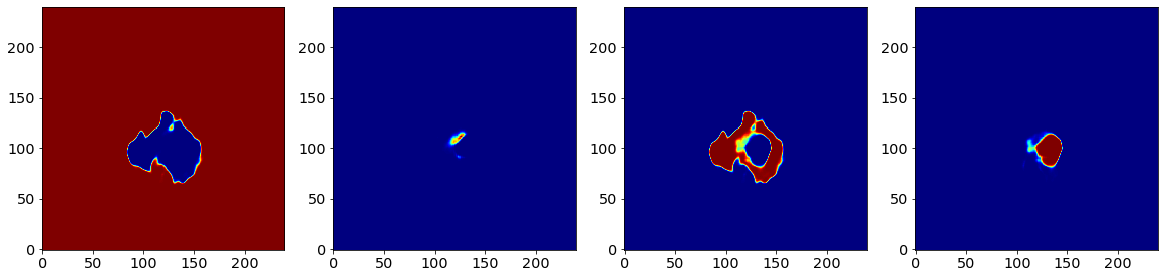

In [127]:
vu.show_n_images([pred_stats[100,:,:,i] for i in range(4)])

In [128]:
pred = prediction_from_probabily_3D(pred_stats)
pred.shape,np.unique(pred)

((155, 240, 240), array([0, 1, 2, 3]))

In [129]:
np.unique(pred)

array([0, 1, 2, 3])

<Figure size 432x360 with 0 Axes>

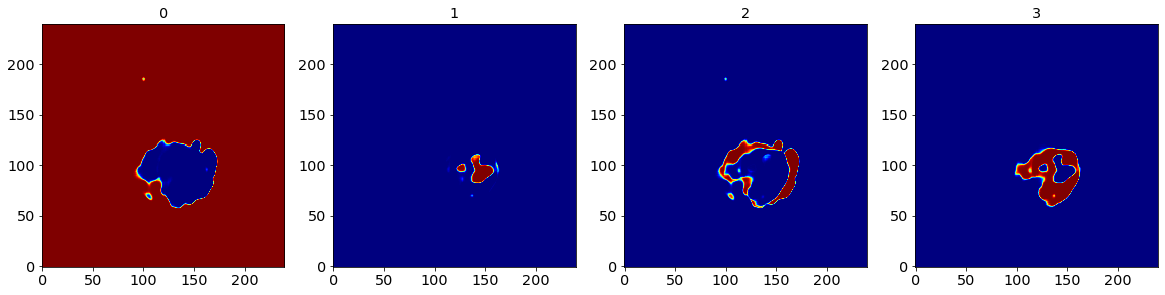

In [130]:
i=70
vu.show_n_images([pred_stats[i,:,:,0],pred_stats[i,:,:,1],pred_stats[i,:,:,2],pred_stats[i,:,:,3]],
                titles=[0,1,2,3])

View predicted probabilities, and the resulted labels

<Figure size 432x360 with 0 Axes>

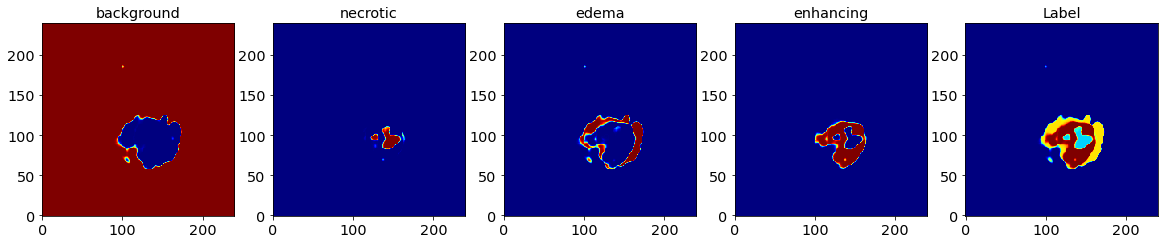

<Figure size 432x360 with 0 Axes>

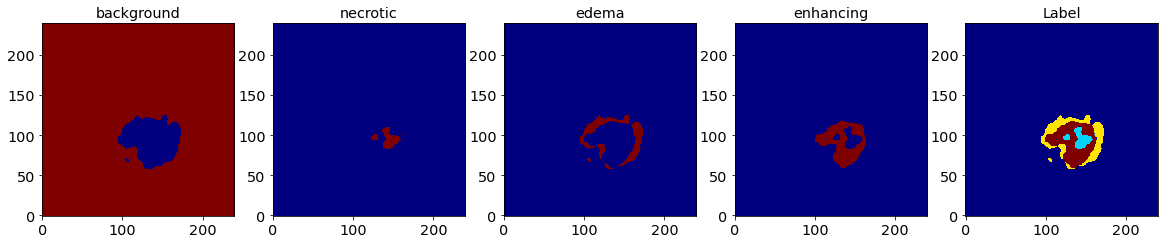

<Figure size 432x360 with 0 Axes>

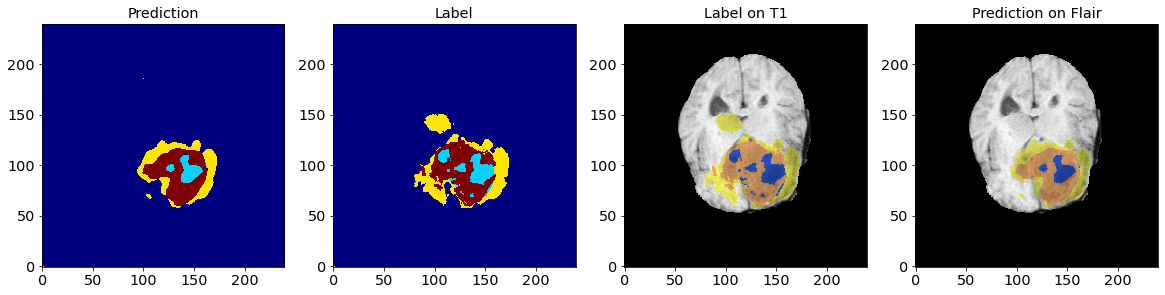

<Figure size 432x360 with 0 Axes>

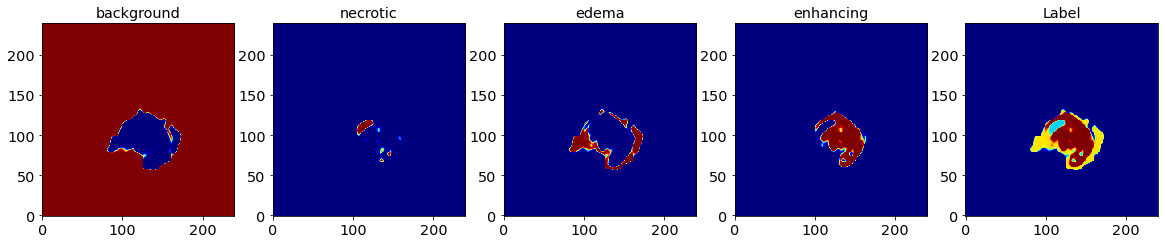

<Figure size 432x360 with 0 Axes>

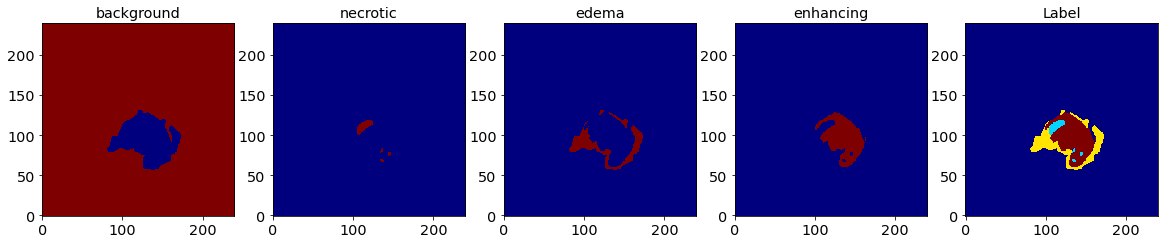

<Figure size 432x360 with 0 Axes>

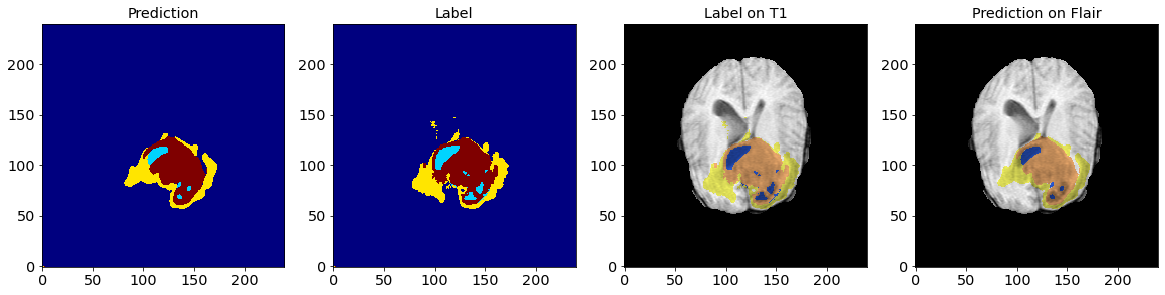

<Figure size 432x360 with 0 Axes>

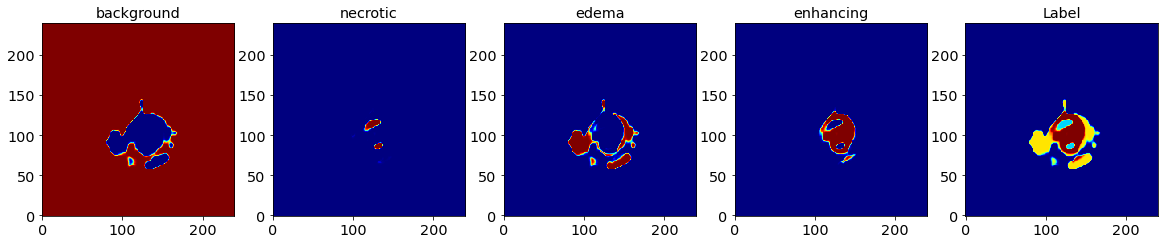

<Figure size 432x360 with 0 Axes>

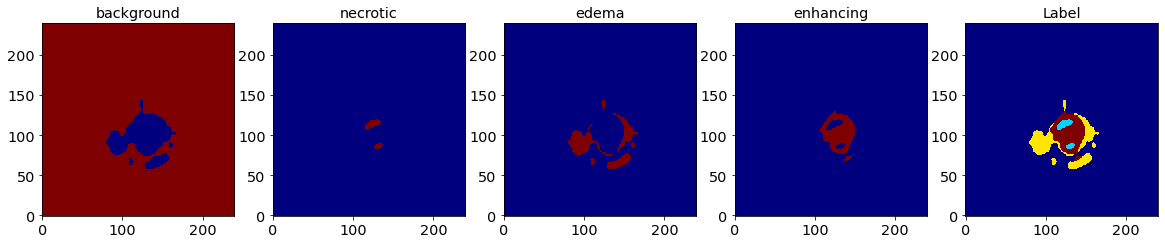

<Figure size 432x360 with 0 Axes>

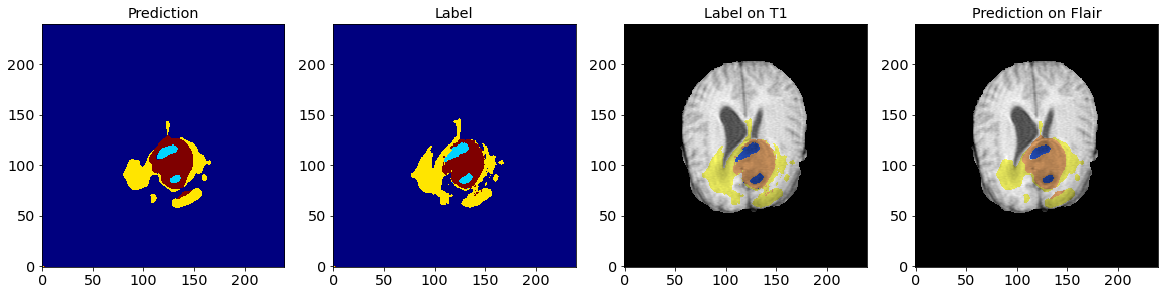

In [131]:
ind=[70,80,90]
for i in ind:
    show_lable(pred_stats[i])
    show_lable(get_pred(pred_stats[i]))
    show_pred_im_lable(im[i], lb[i], pred[i])

## Predict all test images to calculate IOU

In [132]:
TEST_PRED_NUMPY_DIR = 'dicom/predictions/pred2/test/numpy_images/'
VALIDATION_PRED_NUMPY_DIR = 'dicom/predictions/pred2/validation/numpy_images/'
VALIDATION_PRED_NII_DIR = 'dicom/predictions/pred2/validation/nii2/'

Check that its all working -:)

In [133]:
img_id = 'BraTS19_TCIA01_203_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_TCIA01_203_1')
im.shape,lb.shape

nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

pred = prediction_from_probabily_3D(pred_stats)
pred.shape

(155, 240, 240)

<Figure size 432x360 with 0 Axes>

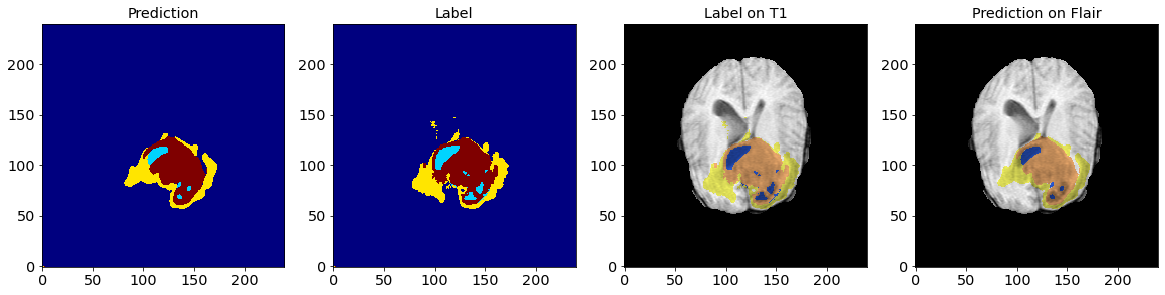

In [134]:
show_pred_im_lable(im[80], lb[80], pred[80])

In [135]:
TEST_PRED_NUMPY_DIR='dicom/predictions/pred2/test/numpy_images/'

In [136]:
for index, row in df_test.iterrows():

    img_id = row['id']
    im,lb = get_numpy_img_lbl(img_id)

    nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')

    np.save(out_img, pred)
    print('Saving: ', out_img)

Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_TCIA01_203_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_CBICA_ATV_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_TCIA02_314_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_CBICA_ARF_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_CBICA_AUN_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_2013_7_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_TCIA10_266_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_2013_0_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_TCIA09_462_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_TMC_06643_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_TCIA01_201_1_pred.npy
Saving:  dicom/predictions/pred2/test/numpy_images/BraTS19_TCIA06_165_1_pred.npy
Saving:  dicom/predictions/pred2/test/nu

In [137]:
img_id='BraTS19_TCIA10_393_1'
im,lb = get_numpy_img_lbl(img_id)
out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')
pred = np.load(out_img)

<Figure size 432x360 with 0 Axes>

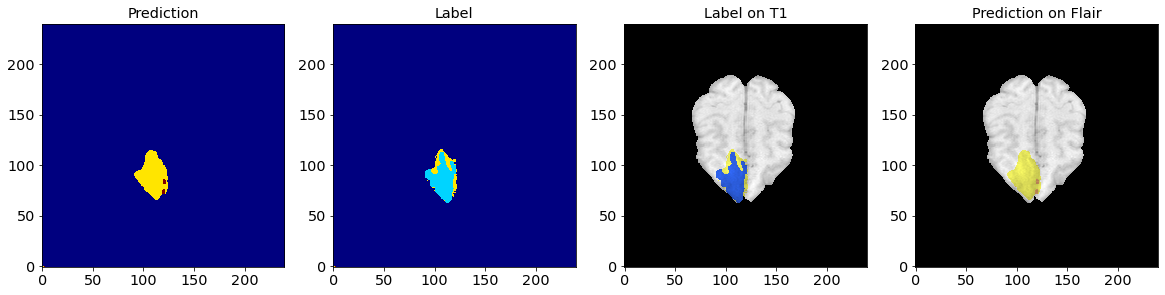

In [138]:
show_pred_im_lable(im[120], lb[120], pred[120])

<Figure size 432x360 with 0 Axes>

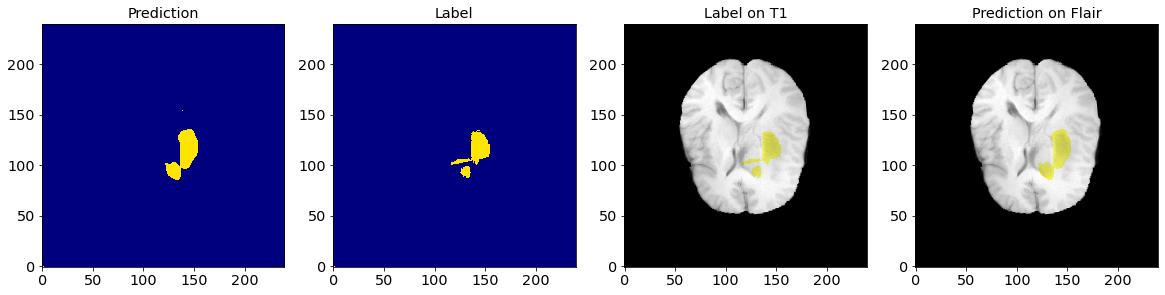

<Figure size 432x360 with 0 Axes>

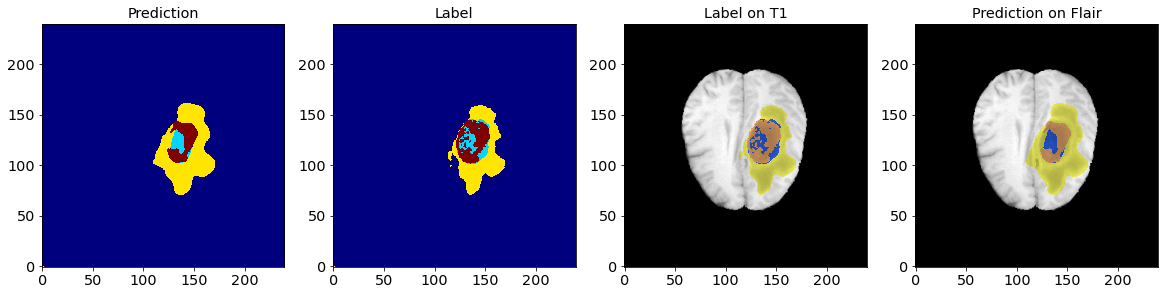

In [139]:
img_id='BraTS19_2013_7_1'
im1,lb1 = get_numpy_img_lbl(img_id)
out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')
pred1 = np.load(out_img)
show_pred_im_lable(im1[80], lb1[80], pred1[80])
show_pred_im_lable(im1[100], lb1[100], pred1[100])

<Figure size 432x360 with 0 Axes>

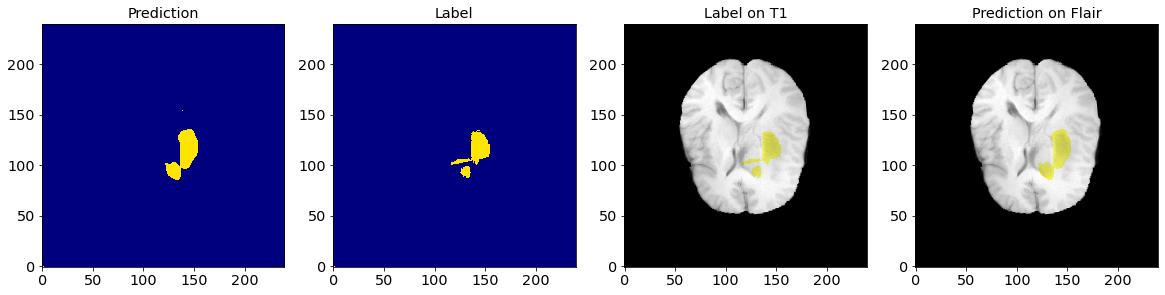

<Figure size 432x360 with 0 Axes>

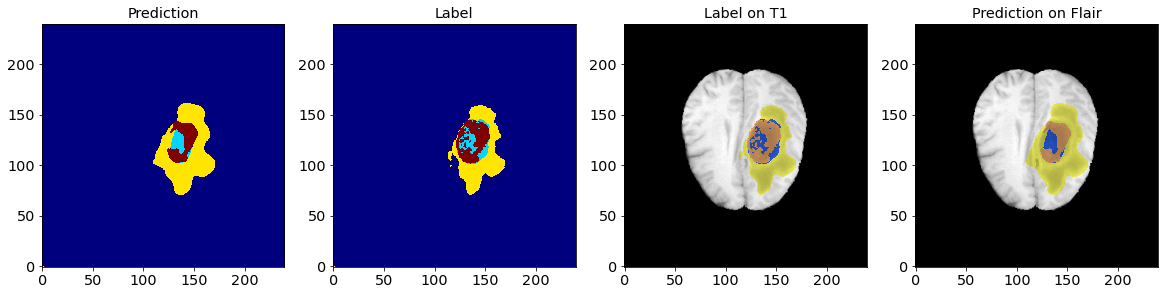

<Figure size 432x360 with 0 Axes>

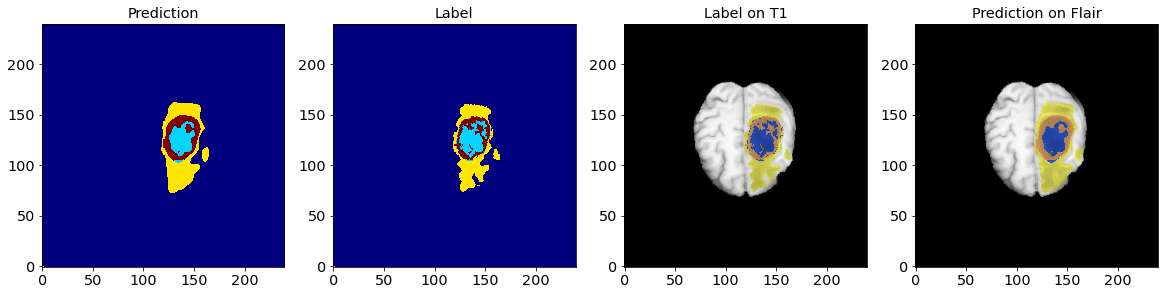

In [140]:
img_id='BraTS19_2013_7_1'
im1,lb1 = get_numpy_img_lbl(img_id)
out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')
pred1 = np.load(out_img)
show_pred_im_lable(im1[80], lb1[80], pred1[80])
show_pred_im_lable(im1[100], lb1[100], pred1[100])
show_pred_im_lable(im1[120], lb1[120], pred1[120])

In [141]:
im, lb = get_df_img_batch(df_test.iloc[0:20])

In [142]:
pred = model.predict(im)

In [143]:
predl = prediction_from_probabily_3D(pred)

In [144]:
im.shape, lb.shape, pred.shape, predl.shape

((1509, 240, 240, 4),
 (1509, 240, 240, 4),
 (1509, 240, 240, 4),
 (1509, 240, 240))

In [145]:
lbl = get_label_from_pred_batch(lb)
lbl.shape

(1509, 240, 240)

In [146]:
lblc = pred_from_categorical(lb)
lblc.shape

(1509, 240, 240)

<Figure size 432x360 with 0 Axes>

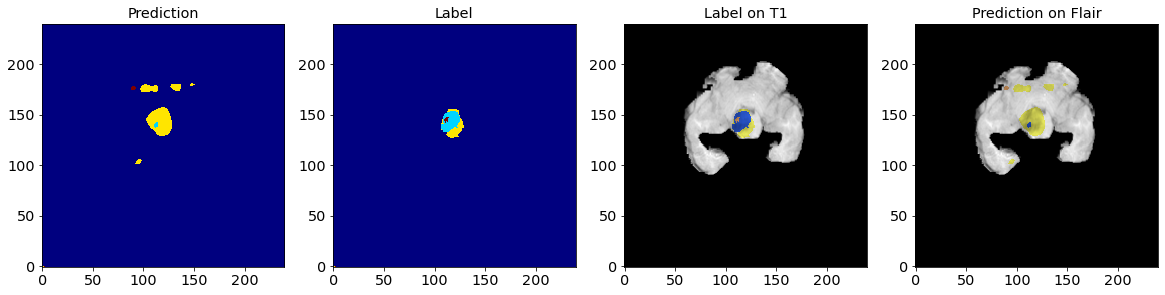

In [147]:
i=500
show_pred_im_lable(im[i], lblc[i], predl[i])

In [148]:
np.unique(lblc[i]), np.unique(predl[i])

(array([0, 1, 2, 3], dtype=uint8), array([0, 1, 2, 3]))

In [149]:
keras.metrics.accuracy(lb,pred)

<tf.Tensor: shape=(1509, 240, 240, 4), dtype=float32, numpy=
array([[[[0., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        ...,

        [[1., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 1., 1.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
        

In [150]:
dice_coef_loss(lb.astype(np.float32),pred)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.98437506>

In [151]:
df_test.shape, df_train.shape

((23, 13), (268, 25))

In [152]:
from sklearn.metrics import accuracy_score
accuracy_score(lblc.flatten(),predl.flatten())

0.9847252710588322

In [153]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(lblc.flatten(),predl.flatten())

In [154]:
cm

array([[83961334,     7025,   254652,    22079],
       [  125084,   286793,   229445,    55447],
       [  303688,    79940,   994891,    49868],
       [   99231,    21334,    79862,   347727]])

In [155]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [156]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (15,15), fontsize=8):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())#, rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [157]:
labels = ['0','1','2','3']
cmdf=pd.DataFrame(cm, index=labels, columns=labels)
cmdf

,0,1,2,3
0,83961334,7025,254652,22079
1,125084,286793,229445,55447
2,303688,79940,994891,49868
3,99231,21334,79862,347727


In [158]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmdfn=pd.DataFrame(cmn, index=labels, columns=labels)
cmdfn

,0,1,2,3
0,0.996632,0.000083,0.003023,0.000262
1,0.179520,0.411604,0.329299,0.079577
2,0.212609,0.055965,0.696514,0.034912
3,0.181028,0.038920,0.145693,0.634360


In [159]:
# labels = ['0','1','2','3']
# for colname, th in th_dict.items():
#     cm = confusion_matrix(y_true=radar['Type'], 
#                           y_pred=radar[colname], 
#                           labels=labels)
#     cm = pd.DataFrame(cm, index=labels, columns=labels)
#     print ("Threshold:", th, '\n',colname,"\n--------------")
#     #print( cm, '\n')
#     print_confusion_matrix(cm, labels)
#     plt.show()

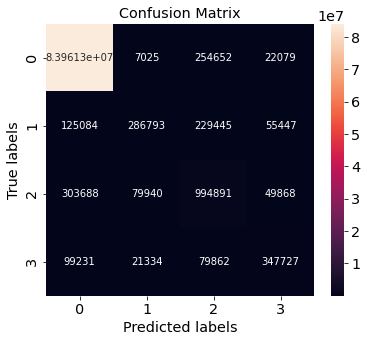

In [160]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g',ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0','1','2','3']); ax.yaxis.set_ticklabels(['0','1','2','3']);

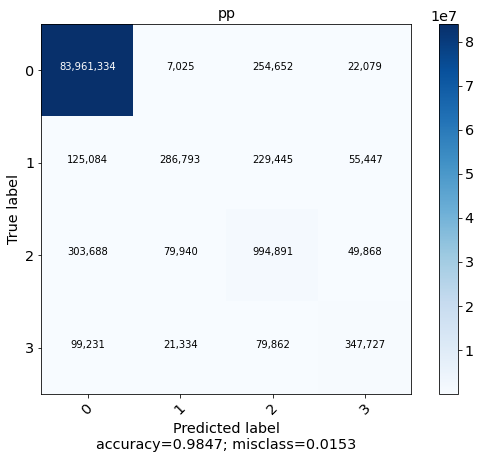

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy


cmap = plt.get_cmap('Blues')
normalize = False
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('pp')
plt.colorbar()

target_names=['0','1','2','3']
if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.show()

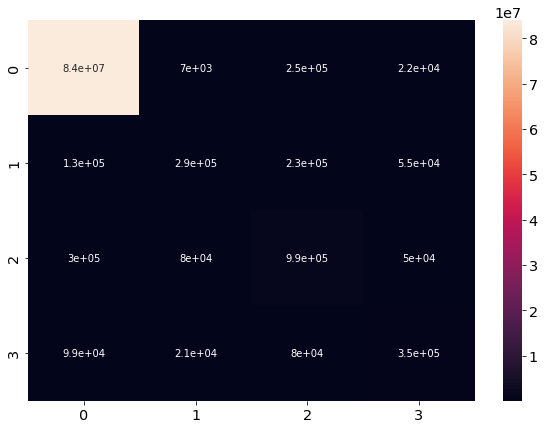

In [162]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

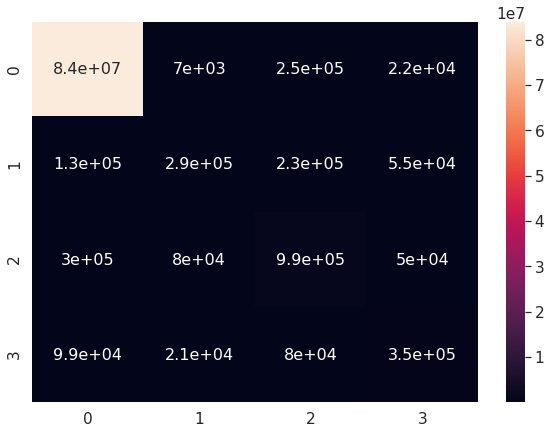

In [163]:
df_cm = pd.DataFrame(cm, range(4),
                  range(4))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

plt.show()

In [164]:
lb.shape, pred.shape,lb[:,:,:, 0].shape

((1509, 240, 240, 4), (1509, 240, 240, 4), (1509, 240, 240))

In [165]:
from sklearn.metrics import roc_curve
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
l=lb.reshape(1509*240*240,4)
p=pred.reshape(1509*240*240,4)
# for i in range(4):
#     print(l[:,i].shape,p[:,i].shape)
#     fpr[i], tpr[i], _ = roc_curve(l[:,i],p[:,i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

## Predict all validation image

In [166]:
df_val.head()

,id,lab0,lab1,lab2,lab3
0,BraTS19_CBICA_AUC_1,0,0,0,0
1,BraTS19_TCIA10_195_1,0,0,0,0
2,BraTS19_TCIA05_456_1,0,0,0,0
3,BraTS19_TCIA07_600_1,0,0,0,0
4,BraTS19_TCIA13_636_1,0,0,0,0


In [167]:
VALIDATION_NUMPY_DIR

'dicom/MICCAI_BraTS_2019_Data_Validation/numpy_images/'

In [168]:
VALIDATION_PRED_NII_DIR='dicom/predictions/pred2/validation/nii2/'

In [169]:
VALIDATION_PRED_NII_DIR

'dicom/predictions/pred2/validation/nii2/'

In [170]:
VALIDATION_PRED_NUMPY_DIR = 'dicom/predictions/pred2/validation/numpy_images/'

<Figure size 432x360 with 0 Axes>

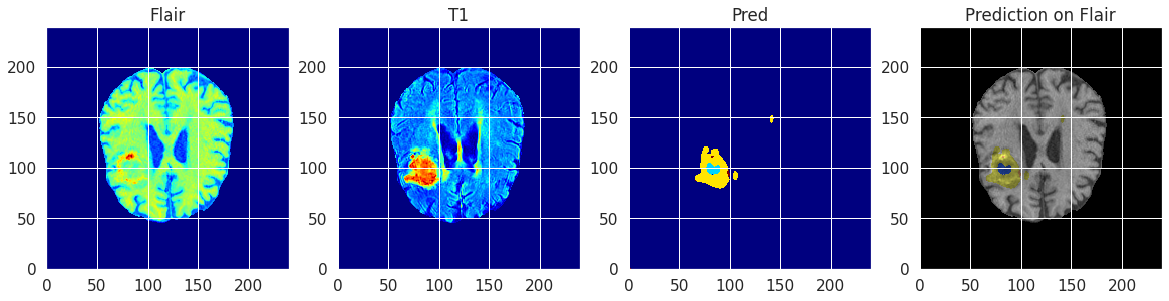

In [171]:
img_id='BraTS19_CBICA_AUC_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[88], pred[88])

<Figure size 432x360 with 0 Axes>

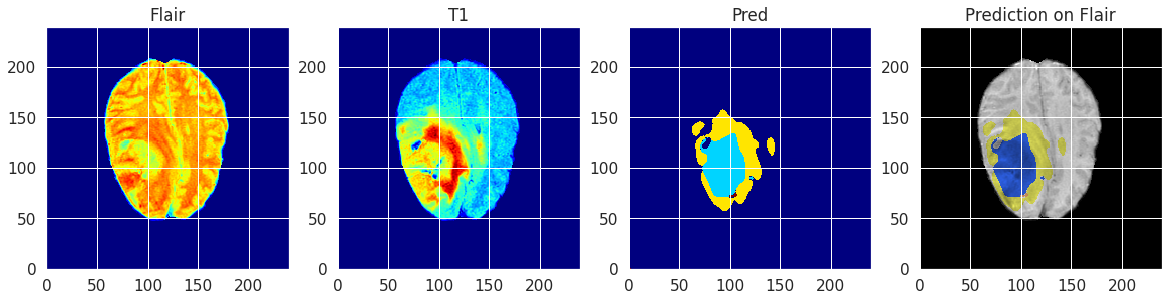

In [172]:
img_id='BraTS19_TCIA10_195_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[100], pred[100])

<Figure size 432x360 with 0 Axes>

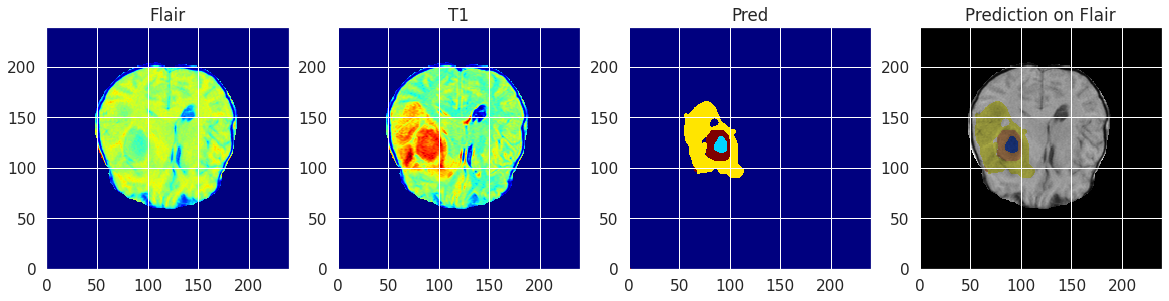

In [173]:
img_id='BraTS19_TCIA05_456_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[78], pred[78])

<Figure size 432x360 with 0 Axes>

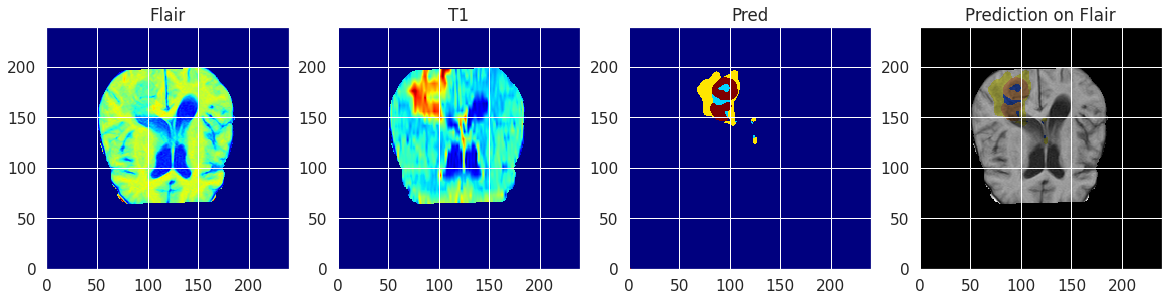

In [174]:
img_id='BraTS19_TCIA07_600_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[80], pred[80])

<Figure size 432x360 with 0 Axes>

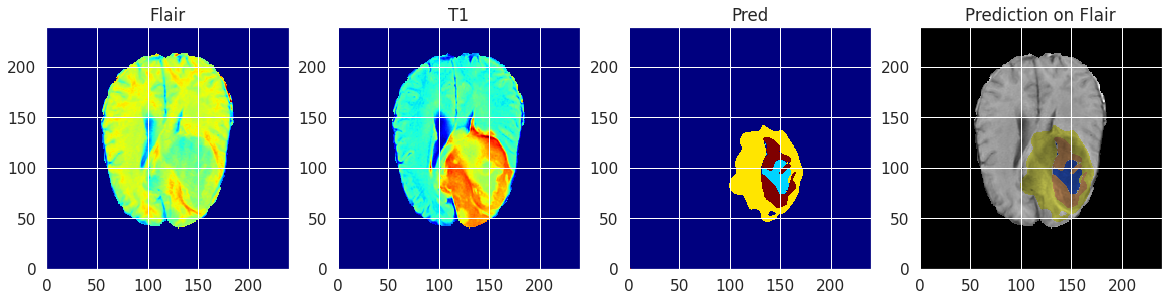

In [175]:
img_id='BraTS19_TCIA13_636_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[88], pred[88])

In [176]:
 np.unique(pred[80])

array([0, 1, 2, 3])

In [ ]:
for index, row in df_val.iterrows():

    img_id = row['id']

    nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(VALIDATION_PRED_NUMPY_DIR, img_id+'_pred.npy')
    np.save(out_img, pred)
    
    pred = np.where(pred==3,4, pred)
    out_nii = os.path.join(VALIDATION_PRED_NII_DIR, img_id+'.nii.gz')

    sitk_img = sitk.GetImageFromArray(pred)
    sitk.WriteImage(sitk_img , out_nii)
    
    print('Saving: ', out_nii)

Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_CBICA_AUC_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA10_195_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA05_456_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA07_600_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA13_636_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_MDA_958_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_WashU_S037_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA02_355_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA10_106_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA06_497_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA02_382_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA02_273_1.nii.gz
Saving:  dicom/predictions/pred2/validation/nii2/BraTS19_TCIA13_646_1.nii.gz
Sav